In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels as sm
import pmdarima as pm

In [2]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.rename(columns=lambda c: str(c), inplace=True)
df["time"] = pd.to_datetime([i for i in range(500)], unit='D', origin=pd.Timestamp('2020-01-01'))
df.set_index("time", inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,13.46,71.65,48.46,50.52,52.10,13.00,18.98,47.71,69.49,49.96,...,32.64,55.76,14.46,58.94,36.71,52.62,49.33,36.22,49.00,56.09
2020-01-02,13.48,72.10,48.52,50.50,52.06,12.95,18.95,47.84,69.73,49.93,...,32.52,55.97,14.44,59.81,36.64,52.58,49.20,36.27,48.84,56.08
2020-01-03,13.47,72.35,48.48,50.62,51.80,12.79,18.98,47.98,69.60,49.33,...,32.48,56.34,14.50,59.04,36.89,52.49,49.48,36.39,48.56,55.90
2020-01-04,13.53,72.51,48.42,50.75,51.66,12.66,18.96,48.74,69.54,49.67,...,32.59,56.32,14.40,58.73,36.94,52.40,49.42,36.41,49.00,56.14
2020-01-05,13.64,71.99,48.40,50.65,51.97,12.62,18.89,48.88,69.68,49.46,...,32.64,56.32,14.36,59.01,37.03,52.44,49.79,36.42,48.14,55.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10,13.69,67.73,46.64,45.72,52.42,10.07,18.05,48.42,69.00,56.19,...,30.73,75.82,10.63,61.35,32.85,50.57,64.36,33.74,33.83,53.47
2021-05-11,13.58,67.75,46.65,45.71,52.57,10.07,17.99,47.65,69.04,56.00,...,30.70,76.46,10.65,61.20,32.60,50.54,64.65,33.78,33.42,53.91
2021-05-12,13.69,67.83,46.66,45.66,52.38,10.02,18.02,46.87,68.95,56.09,...,30.70,75.16,10.75,60.82,32.79,50.42,64.28,33.60,33.75,54.22


In [3]:
train = df.iloc[:400, :]
test = df.iloc[200:, :]

In [4]:
from arch.unitroot.cointegration import engle_granger
from scipy.optimize import minimize
from statsmodels.tsa.vector_ar.vecm import VECM

In [5]:
logprice = np.log(train)
logprice_test = np.log(test)

In [551]:
from arch.unitroot import ADF

for i in range(50):
    t1 = str(i)

    result = ADF(logprice[t1], trend='c')
    if result.pvalue < 0.05:
        print(t1, result.pvalue)

7 0.014875699022375247
9 0.008083678333603525
28 0.04712327342788253
43 0.0063368519532042795
49 0.005026804206181825


<Axes: xlabel='time'>

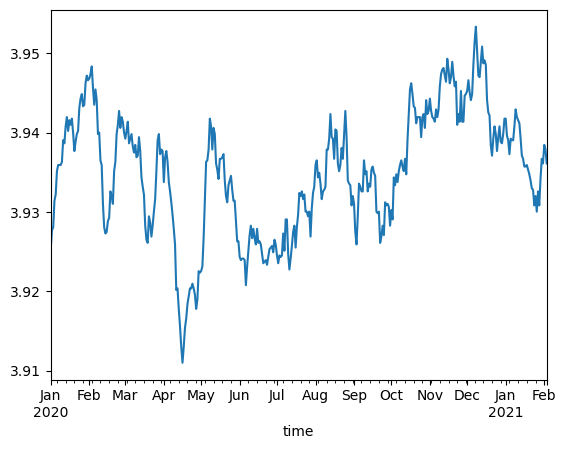

In [558]:
logprice['28'].plot()

In [487]:
exclude = {28,39,11,42,43,49,15,20,1,10,7,8,14,30,22,24,25,36,31,40,33,37}
# exclude = {}
for i in range(50):
    for j in range(i+1,50):
        if i in exclude or j in exclude:
            continue

        t1, t2 =  str(i), str(j)
        result = engle_granger(logprice[t1], logprice[t2], trend='ct', method='bic')
        # result2 = engle_granger(np.log(df)[t1], (np.log(df))[t2], trend='n', method='bic')
        if result.pvalue < 0.1 and result.pvalue > 0.0:
            print(t1,t2,result.pvalue)

2 46 0.09424541098133882
2 47 0.0449345133949129
3 45 0.07432412443357424
4 18 0.08583792466907592
12 21 0.04746485079027769
12 44 0.08672189603414737
12 46 0.07370365056037458
12 47 0.09675653330721662
13 18 0.02381202847236632
38 45 0.04158260137894213
44 47 0.08135230350759587
46 47 0.03822110395401583


In [506]:
coint_result = engle_granger(logprice['3'], logprice['45'], trend="ct", method='bic')
weight = coint_result.cointegrating_vector[:2]
weight

3     1.000000
45   -0.664413
dtype: float64

In [507]:
t1, t2 = '3', '45'
indices = [t1,t2]

<Axes: xlabel='time'>

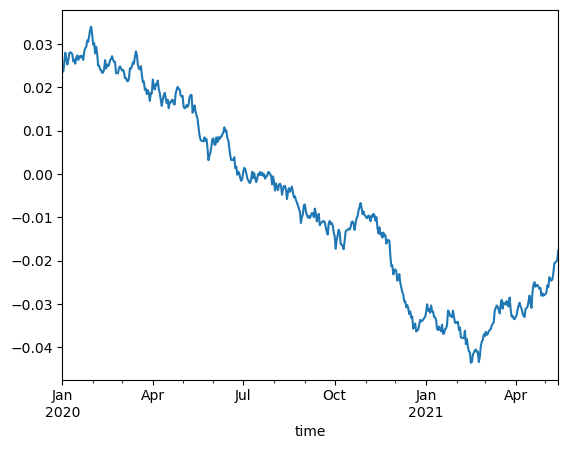

In [508]:
coint_result = engle_granger(logprice[t1], logprice[t2], trend="ct", method='bic')
weight = coint_result.cointegrating_vector[:2]
coint_result

beta = weight.values
beta /= np.sum(np.abs(beta))
beta 

spread = logprice[indices] @ beta
also = (np.log(df))[indices] @ beta
(also-np.mean(spread)).plot()

In [494]:
beta = weight.values
beta /= np.sum(np.abs(beta))
beta 

array([ 0.84971955, -0.15028045])

<Axes: xlabel='time'>

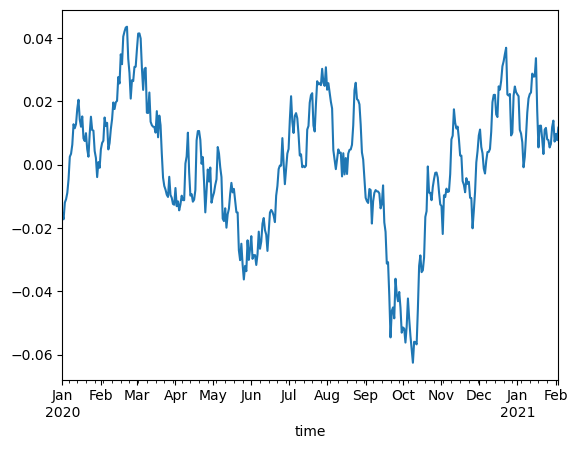

In [495]:
# beta = vecm_result.beta
spread = logprice[indices] @ beta

(spread-np.mean(spread)).plot()

<Axes: xlabel='time'>

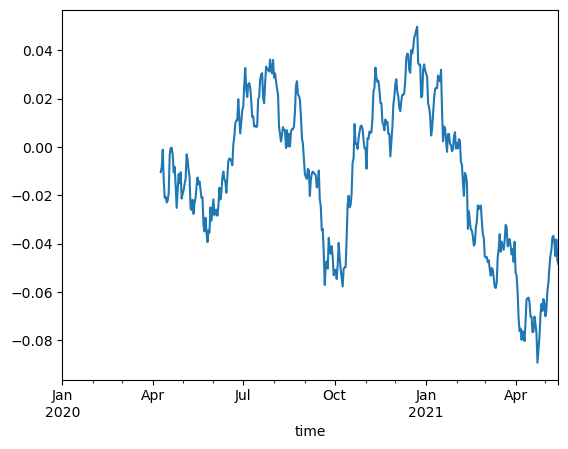

In [498]:
also = (np.log(df))[indices] @ beta
(also-also.rolling(100).mean()).plot()

In [499]:
spread = spread - np.mean(spread)

The optimal threshold is 0.01958165613052095


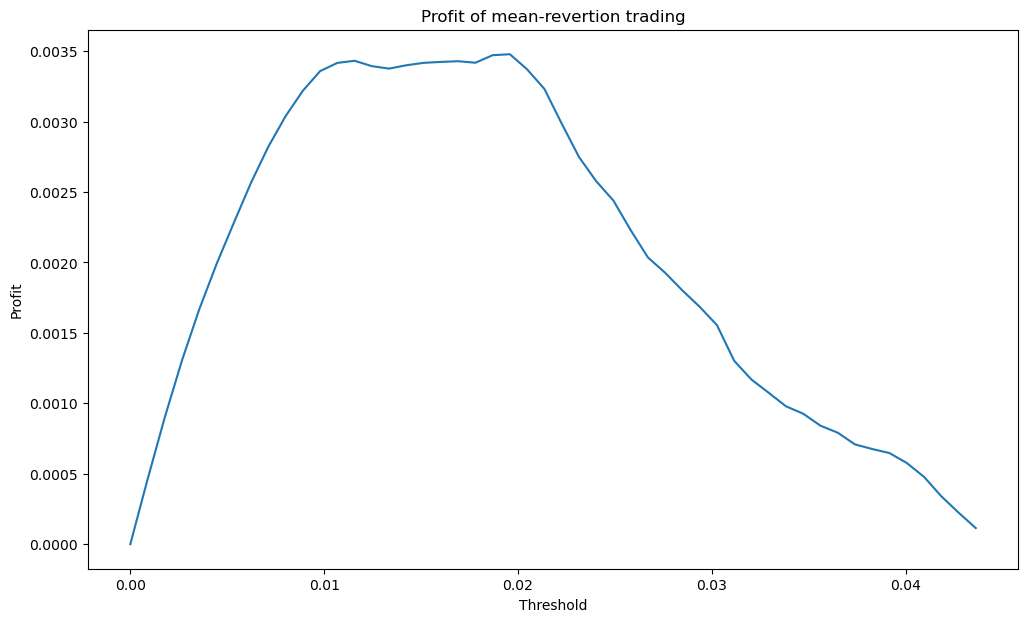

In [500]:
s0 = np.linspace(0, spread.max(), 50)
f_bar = np.array([None]*50)
for i in range(50):
    f_bar[i] = len(spread.values[spread.values > s0[i]]) / spread.shape[0]

D = np.zeros((49, 50))
for i in range(D.shape[0]):
    D[i, i] = 1
    D[i, i+1] = -1

l = 1.0
f_star = np.linalg.inv(np.eye(50) + l * D.T@D) @ f_bar.reshape(-1, 1)
s_star = [f_star[i]*s0[i] for i in range(50)]

threshold = s0[s_star.index(max(s_star))]
print(f"The optimal threshold is {threshold}")

plt.figure(figsize=(12, 7))
plt.plot(s0, s_star)
plt.title("Profit of mean-revertion trading")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.show()


In [501]:
# testing
train_spread = (np.log(train))[[t1,t2]] @ beta
spread = (np.log(test))[[t1,t2]] @ beta
normalized = spread - np.mean(train_spread)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

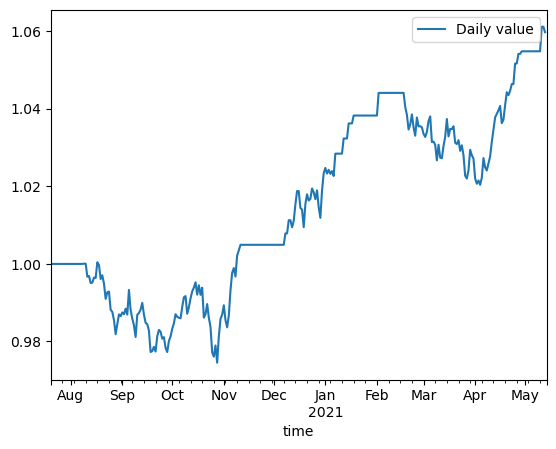

<Figure size 640x480 with 0 Axes>

In [502]:
trading_weight = beta
trading_weight /= np.sum(abs(trading_weight))

testing_ret = test[[t1,t2]].pct_change().iloc[1:].shift(-1)   # Shift 1 step backward as forward return result
equity = pd.DataFrame(np.ones((testing_ret.shape[0], 1)), index=testing_ret.index, columns=["Daily value"])

retspread = normalized.iloc[1:]
buy_period = retspread[retspread < -threshold].dropna().index
sell_period = retspread[retspread > threshold].dropna().index
# print(retspread[retspread < -threshold])

# print(equity.loc[buy_period, "Daily value"])
# print(testing_ret.loc[buy_period] @ trading_weight + 1)
equity.loc[buy_period, "Daily value"] = (testing_ret.loc[buy_period] @ trading_weight + 1)
equity.loc[sell_period, "Daily value"] = (testing_ret.loc[sell_period] @ -trading_weight + 1)

plt.figure()
value = equity.cumprod()
value.plot()
plt.figure()
# plt.plot(retspread[retspread < -threshold].astype('int') - retspread[retspread > threshold].astype('int'))
# plt.plot(retspread[retspread > threshold].notnull().astype('int'))


In [972]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.arange(value.size), value["Daily value"])
r_value ** 2

nan

In [943]:
value

,Daily value
time,
2020-07-20,1.000000
2020-07-21,1.000000
2020-07-22,1.000000
2020-07-23,1.000000
2020-07-24,1.000000
...,...
2021-05-10,1.179005
2021-05-11,1.179005
2021-05-12,1.179005


In [484]:
print(threshold)
print(list(trading_weight.T))
print(np.mean(train_spread))

0.009495547155043802
[0.49488551387751106, -0.505114486122489]
4.36136606091303e-05


In [485]:
t1, t2

('44', '47')

In [946]:
list(trading_weight.T)

[0.6305726535836199, -0.36942734641638003]

In [518]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [539]:
scaler = MinMaxScaler(feature_range = (0, 1))
nn = pd.DataFrame(scaler.fit_transform(df['6'].values.reshape(-1,1)), index=df.index)
input_ = nn[:-1]
output = nn.shift(-1).iloc[:-1]

splitter = int(input_.shape[0] * 0.7)
X_train = input_.iloc[:splitter]
X_test = input_.iloc[splitter:]
y_train = output.iloc[:splitter]
y_test = output.iloc[splitter:]

In [540]:
features_set = []
labels = []
for i in range(60, X_train.shape[0]):
    features_set.append(X_train.iloc[i-60:i].values.reshape(-1, 1))
    labels.append(y_train.iloc[i])
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [541]:
model = Sequential()
# Add our first LSTM layer - 50 nodes.
model.add(LSTM(units = 50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
# Add Dropout layer to avoid overfitting
model.add(Dropout(0.2))
# Add additional layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 5))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'acc'])
callback = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                

In [542]:
model.fit(features_set, labels, epochs = 50, batch_size = 100, callbacks=[])

Epoch 1/50
3/3 [==============================] - 4s 106ms/step - loss: 0.1391 - mae: 0.3345 - acc: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 0s 102ms/step - loss: 0.0319 - mae: 0.1419 - acc: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 0s 105ms/step - loss: 0.0261 - mae: 0.1269 - acc: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 0s 99ms/step - loss: 0.0207 - mae: 0.1146 - acc: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 0s 105ms/step - loss: 0.0254 - mae: 0.1271 - acc: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 0s 98ms/step - loss: 0.0166 - mae: 0.1028 - acc: 0.0000e+00
Epoch 7/50
3/3 [==============================] - 0s 101ms/step - loss: 0.0144 - mae: 0.0976 - acc: 0.0000e+00
Epoch 8/50
3/3 [==============================] - 0s 99ms/step - loss: 0.0160 - mae: 0.1018 - acc: 0.0000e+00
Epoch 9/50
3/3 [==============================] - 0s 104ms/step - loss: 0.0117 - mae: 0.0866 - acc: 0.0000e+00
Epoc

In [543]:
test_features = []
for i in range(60, X_test.shape[0]):
    test_features.append(X_test.iloc[i-60:i].values.reshape(-1, 1))
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

10/10 [==============================] - 0s 16ms/step


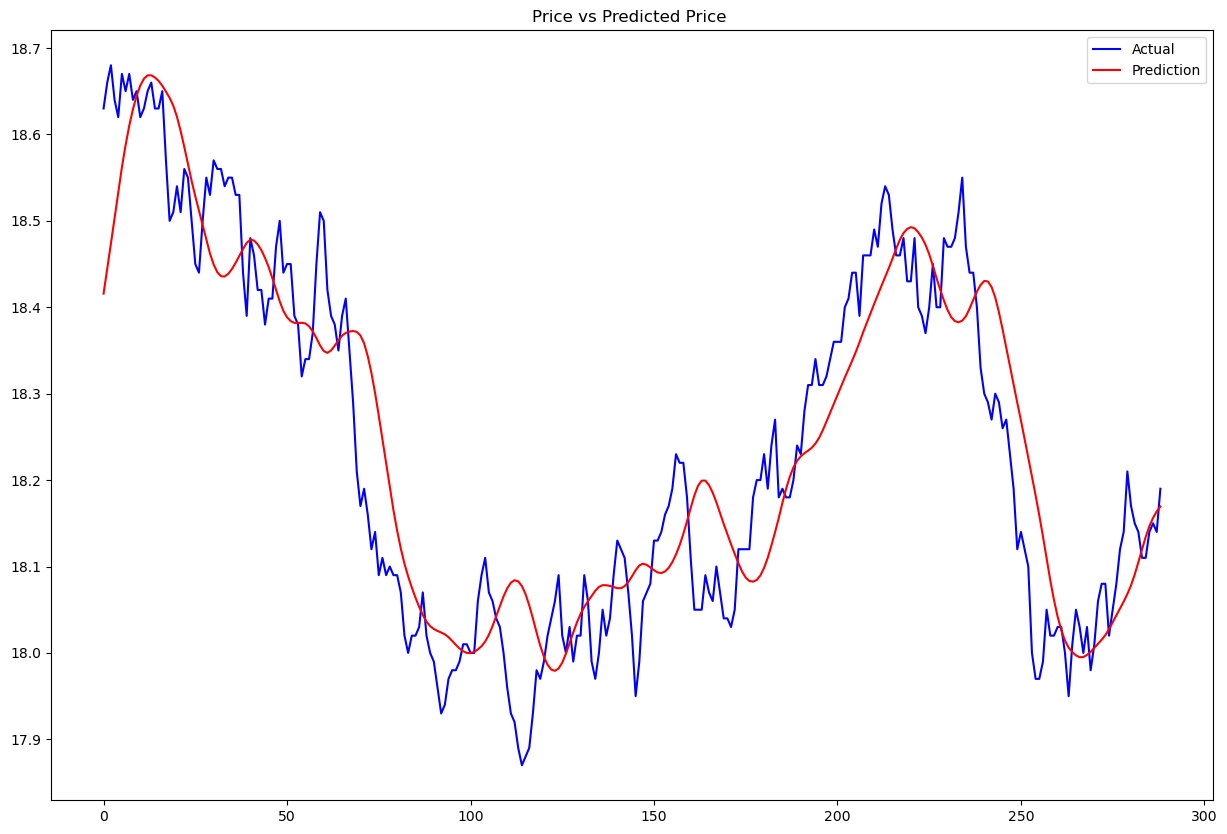

In [546]:
predictions = model.predict(features_set)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_train.values)
plt.figure(figsize=(15, 10))
plt.plot(actual[60:], color='blue', label='Actual')
plt.plot(predictions , color='red', label='Prediction')
plt.title('Price vs Predicted Price ')
plt.legend()
plt.show()

In [669]:
classifier = test.le(test.rolling(30).mean() - test.rolling(30).std())

In [646]:
from scipy.stats import norm, zscore

In [670]:
z_score = test.apply(zscore)[classifier]
magnitude = -z_score * test.rolling(30).std() / test.shift(1)
confidence = (-z_score).apply(norm.cdf)

In [671]:
magnitude.fillna(0, inplace=True)
confidence.fillna(0, inplace=True)

In [672]:
weight = confidence - 1 / (magnitude + 1)
weight = weight[weight > 0].fillna(0)
sum_ = np.sum(weight, axis=1)
for i in range(weight.shape[0]):
    if sum_[i] > 0:
        weight.iloc[i] = weight.iloc[i] / sum_[i]
    else:
        weight.iloc[i] = 0
weight = weight.iloc[:-1]

In [673]:
weight.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,299.0,299.0,299.0,299.0,299.0,299.000000,299.0,299.000000,299.0,299.000000,...,299.0,299.0,299.000000,299.0,299.000000,299.000000,299.0,299.0,299.000000,299.0
mean,0.0,0.0,0.0,0.0,0.0,0.006171,0.0,0.013378,0.0,0.003344,...,0.0,0.0,0.012238,0.0,0.016390,0.000791,0.0,0.0,0.035164,0.0
std,0.0,0.0,0.0,0.0,0.0,0.035506,0.0,0.115079,0.0,0.057831,...,0.0,0.0,0.060887,0.0,0.096113,0.005698,0.0,0.0,0.174211,0.0
min,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
max,0.0,0.0,0.0,0.0,0.0,0.450048,0.0,1.000000,0.0,1.000000,...,0.0,0.0,0.411264,0.0,1.000000,0.052555,0.0,0.0,1.000000,0.0


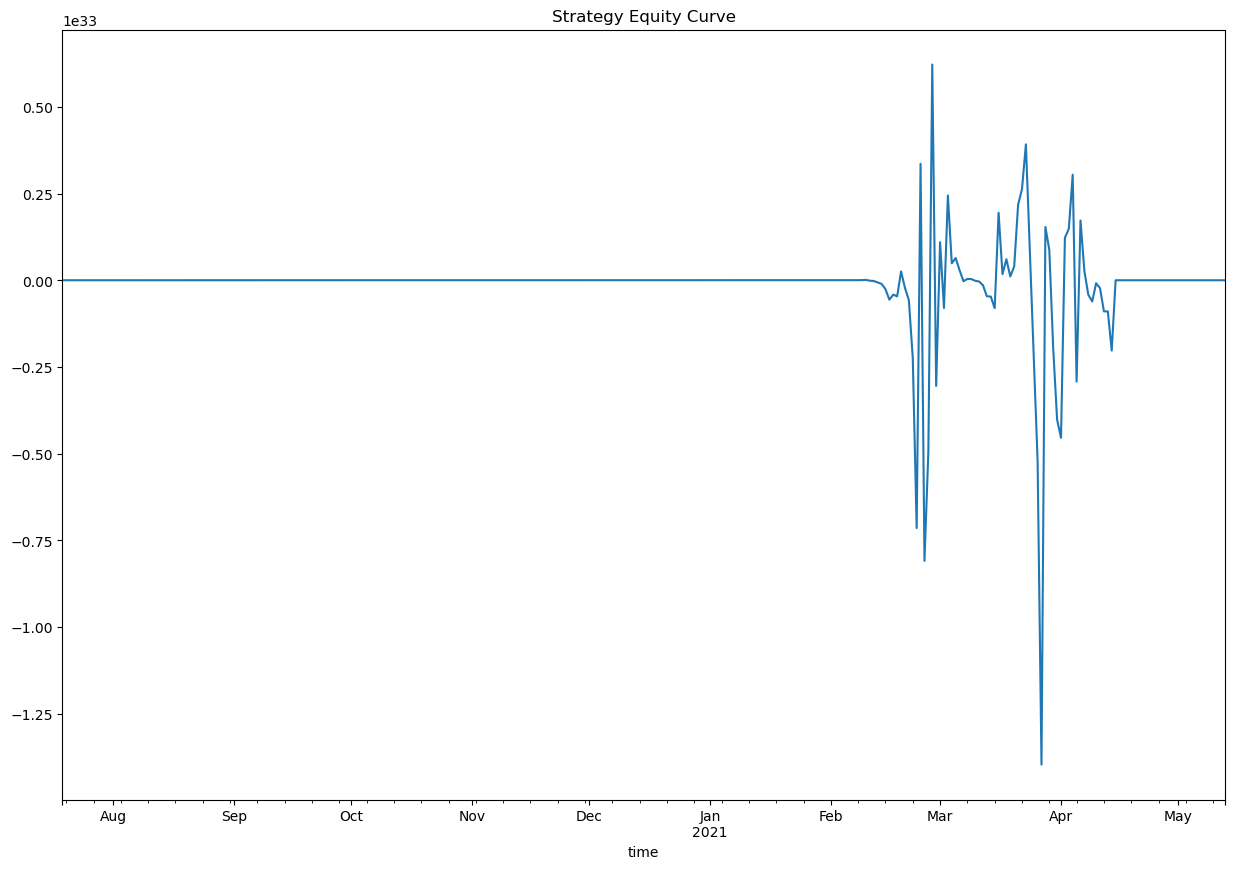

In [674]:
ret = pd.Series(index=range(test.shape[0] - 1))
for i in range(test.shape[0] - 1):
    ret[i] = test.iloc[i] @ test.pct_change().iloc[i + 1].T

total_ret = (ret + 1).cumprod()
total_ret.index = weight.index
total_ret.plot(title='Strategy Equity Curve', figsize=(15, 10))
plt.show()